In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from transformers import TFBertModel, BertTokenizer, AutoTokenizer, TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dropout, Dense 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow as tf 
import tensorflow.keras.backend as K
from keras.utils.np_utils import to_categorical

## for data
import pandas as pd
import numpy as np
import re
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report, ConfusionMatrixDisplay

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns


from typing import Dict, List, Tuple
import codecs
from text_unidecode import unidecode


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

In [7]:
# !conda install -c conda-forge h5py -y

## Load Data

In [8]:
def read_data(path:str, file_type:str)-> pd.DataFrame:
    if glob.glob(path+file_type+".csv"):
        df = pd.read_csv(path+file_type+".csv")
    
    essay_dict = {}
    for file in glob.glob(path+file_type+'/*.txt'): 
        with open(file, "r") as file_open:
            filename = file.split(file_type+'/')[1].split('.txt')[0]
            essay_dict[filename] = file_open.read()
        
    essay_data = pd.DataFrame.from_dict([essay_dict]).T.reset_index()
    essay_data.columns = ["essay_id", "essay_text"]
    train_data = pd.merge(df,essay_data,left_on = 'essay_id', right_on ='essay_id', how ='left')
    print(file_type+" data: ",train_data.shape)
    return train_data

In [9]:
filepath = '/content/drive/MyDrive/fourthbrain/Effective_Writing_Feedback/data/'
train_data = read_data(filepath, 'train')
test_data = read_data(filepath, 'test')
print(train_data.shape, test_data.shape)

train data:  (36765, 6)
test data:  (21, 5)
(36765, 6) (21, 5)


In [10]:
AUTO = tf.data.experimental.AUTOTUNE
# Configuration
EPOCHS = 10
BATCH_SIZE = 16
MAX_LEN = 256
MODEL_TYPE="distilbert"

In [11]:
# https://www.kaggle.com/competitions/feedback-prize-2021/discussion/313330
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

In [12]:
def cleanup_text(text):
    punctuation_signs = list("?:!,;")
    text = text.replace("\n","")
    text = text.replace("\r", " ")
    text = text.replace("    ", " ")
    text = text.replace('"', '')
    text = text.replace("'s", "")
    for punct_sign in punctuation_signs:
      text = text.replace(punct_sign, '')
    words = re.sub(pattern = '[^a-zA-Z]',repl = ' ', string = text)
    words = words.lower()
    return words


train_data['processed_discourse'] = train_data['discourse_text'].apply(cleanup_text)
train_data['processed_essay'] = train_data['essay_text'].apply(cleanup_text)


test_data['normalized_discourse'] = test_data['discourse_text'].apply(resolve_encodings_and_normalize)
test_data['processed_discourse'] = test_data['normalized_discourse'].apply(cleanup_text)

test_data['processed_essay'] = test_data['essay_text'].apply(resolve_encodings_and_normalize)
test_data['processed_essay'] = test_data['processed_essay'].apply(cleanup_text)
display(test_data[test_data['discourse_id'] == '84942fc2ab0f'].head(1))

,discourse_id,essay_id,discourse_text,discourse_type,essay_text,normalized_discourse,processed_discourse,processed_essay
12,84942fc2ab0f,A8445CABFECE,"According to an article by the Edgar Snyder Firm, 21% of teens that were part of a fatal car accident was due to phones. According to the same article, 35% know the risk but continue using their phones while on the road. This shows that its beyond dangerous and irresponsible of drivers not to be fully aware of their surroundings while driving. Drivers should be able to concentrate without any distractions, because it could be fatal.According to another article, ""Distracted Driving"" by the NHTSA, there has already been about 3,000 phone related car accident deaths since 2017. The article states that teen get too distracted with their phones, which causes their accident. Accidents that can be easily avoided by focusing on the road and not a phone. Drivers should not be able to use their phones at all while driving.",Evidence,"Phones & Driving\n\nDrivers should not be able to use phones while operating a vehicle. Drivers who used their phone while operating a vehicle are most likely to get into an accident that could be fatal.\n\nAccording to an article by the Edgar Snyder Firm, 21% of teens that were part of a fatal car accident was due to phones. According to the same article, 35% know the risk but continue using their phones while on the road. This shows that its beyond dangerous and irresponsible of drivers not to be fully aware of their surroundings while driving. Drivers should be able to concentrate without any distractions, because it could be fatal.\n\nAccording to another article, ""Distracted Driving"" by the NHTSA, there has already been about 3,000 phone related car accident deaths since 2017. The article states that teen get too distracted with their phones, which causes their accident. Accidents that can be easily avoided by focusing on the road and not a phone. Drivers should not be able to use their phones at all while driving.\n\nIn conclusion, drivers should not able to work a vehicle while using their cell phone. Drivers who uses their phones while operating a vehicle and are likely to have an accident then those who don't.","According to an article by the Edgar Snyder Firm, 21% of teens that were part of a fatal car accident was due to phones. According to the same article, 35% know the risk but continue using their phones while on the road. This shows that its beyond dangerous and irresponsible of drivers not to be fully aware of their surroundings while driving. Drivers should be able to concentrate without any distractions, because it could be fatal.According to another article, ""Distracted Driving"" by the NHTSA, there has already been about 3,000 phone related car accident deaths since 2017. The article states that teen get too distracted with their phones, which causes their accident. Accidents that can be easily avoided by focusing on the road and not a phone. Drivers should not be able to use their phones at all while driving.",according to an article by the edgar snyder firm of teens that were part of a fatal car accident was due to phones according to the same article know the risk but continue using their phones while on the road this shows that its beyond dangerous and irresponsible of drivers not to be fully aware of their surroundings while driving drivers should be able to concentrate without any distractions because it could be fatal according to another article distracted driving by the nhtsa there has already been about phone related car accident deaths since the article states that teen get too distracted with their phones which causes their accident accidents that can be easily avoided by focusing on the road and not a phone drivers should not be able to use their phones at all while driving,phones drivingdrivers should not be able to use phones while operating a vehicle drivers who used their phone while operating a vehicle are most like

## BERT Encoder

In [13]:
if MODEL_TYPE=="bert":
    tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif MODEL_TYPE=="distilbert":
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
sep = tokenizer.sep_token


In [14]:
train_data['inputs'] = train_data.discourse_type + sep +train_data.discourse_text
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text,processed_discourse,processed_essay,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform on my perspective i think that the face is a natural landform because i dont think that there is any life on mars in these next few paragraphs i ll be talking about how i think that is is a natural landformi think that the face is a natural landform because there is no life on mars that we have descovered yet if life was on mars we would know by now the reason why i think it is a natural landform because nobody live on mars in order to create the figure it says in paragraph it not easy to target cydonia in which he is saying that its not easy to know if it is a natural landform at this point in all that they re saying its probably a natural landform people thought that the face was formed by alieans because they thought that there was life on mars though some say that life on mars does exist i think that there is no life on mars it says in paragraph on april mars global surveyor flew over cydonia for the first time michael malin took a picture of mars with his orbiter camera that the face was a natural landform everyone who thought it was made by alieans

In [15]:
bin_map = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
train_data = train_data.replace(bin_map)
train_data = train_data.rename(columns = {"discourse_effectiveness": "label"})


In [16]:
train_data.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,label,essay_text,processed_discourse,processed_essay,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,1,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.\n\nPeople thought that the face was formed by alieans because they thought that there was life on Mars. though some say that life on Mars does exist, I think that there is no life on Mars.\n\nIt says in paragraph 7, on April 5, 1998, Mars Global Surveyor flew over Cydonia for the first time. Michael Malin took a picture of Mars with his Orbiter Camera, that the face was a natural landform. Everyone who thought it was made by alieans even though it wasn't, was not satisfied. I think they were not satisfied because they have thought since 1976 that it was really formed by alieans.\n\nThough people were not satified about how the landform was a natural landform, in all, we new that alieans did not form the face. I would like to know how the landform was formed. we know now that life on Mars doesn't exist.",hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform,hi i m isaac i m going to be writing about how this face on mars is a natural landform or if there is life on mars that made it the story is about how nasa took a picture of mars and a face was seen on the planet nasa doesn t know if the landform was created by life on mars or if it is just a natural landform on my perspective i think that the face is a natural landform because i dont think that there is any life on mars in these next few paragraphs i ll be talking about how i think that is is a natural landformi think that the face is a natural landform because there is no life on mars that we have descovered yet if life was on mars we would know by now the reason why i think it is a natural landform because nobody live on mars in order to create the figure it says in paragraph it not easy to target cydonia in which he is saying that its not easy to know if it is a natural landform at this point in all that they re saying its probably a natural landform people thought that the face was formed by alieans because they thought that there was life on mars though some say that life on mars does exist i think that there is no life on mars it says in paragraph on april mars global surveyor flew over cydonia for the first time michael malin took a picture of mars with his orbiter camera that the face was a natural landform everyone who thought it was made by alieans even though it wasn t wa

In [17]:
train_data.label.value_counts()

1    20977
2     9326
0     6462
Name: label, dtype: int64

In [18]:
from sklearn.model_selection import train_test_split
X_train_text, X_valid_text, y_train, y_valid = train_test_split(train_data['inputs'], train_data['label'], test_size=0.1, random_state=42,\
                                                      stratify=train_data["label"])
#X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

### Begin Embeddings

In [19]:
# Texts, tokenizer inputs and Maxlength of inputs
def bert_encode(texts, tokenizer, max_len=MAX_LEN, distil=False):
    
    input_ids = np.zeros((len(texts), max_len), dtype="int32")
    attention_mask = np.zeros((len(texts), max_len), dtype="int32")
    
    for i, text in enumerate(texts):
        # print(i, text)
        token = tokenizer(text,
                          max_length=max_len,
                          truncation=True,
                          padding='max_length',
                          add_special_tokens=True)

        input_ids[i] = token['input_ids']
        # if not distil:
        #     token_type_ids.append(token['token_type_ids'])
        attention_mask[i] = token['attention_mask']
    
    # if distil:
    #     np.array(input_ids), np.array(attention_mask)
    return input_ids,attention_mask


In [20]:
X_train = bert_encode(X_train_text.astype(str), tokenizer, distil=True)
X_valid = bert_encode(X_valid_text.astype(str), tokenizer, distil=True)

y_train = y_train.values
y_valid = y_valid.values

In [21]:
# X_train

In [22]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

## Building a Bert Model

In [23]:
import gc
gc.collect()

8

In [24]:
from tensorflow.keras import Sequential
import tensorflow_hub as hub


def build_model_bert(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(3, activation='softmax')(clf_output)
    out = Dense(3, activation='relu')(clf_output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def cal_recall(y_true, y_pred):
    y_true = tf.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def cal_precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = cal_precision(y_true, y_pred)
    recall = cal_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_model_distilbert(bert_model, max_len=MAX_LEN):    
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = bert_model(input_ids, attention_mask=attention_mask)[0]
    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(.1)(clf_output)
    out = Dense(3, activation='softmax')(clf_output)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=out)
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=["accuracy",f1_score])
    
    return model

def build_model_use():
    hub_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", output_shape=[512], input_shape=[], dtype=tf.string,
                               trainable=True)
    model = Sequential()
    model.add(hub_layer)
    for units in [16, 8]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=["accuracy",f1_score])
    return model

In [25]:
distil_bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
model  = build_model_distilbert(distil_bert)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

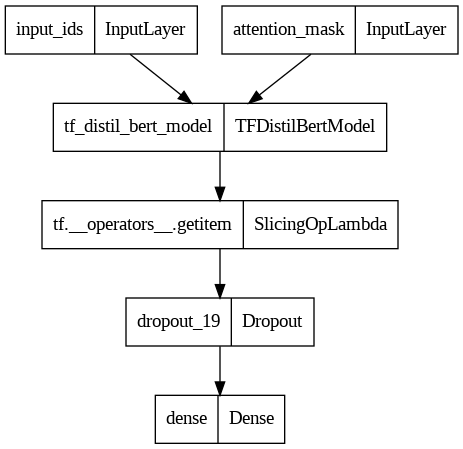

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [29]:
train_history = model.fit(
    train_dataset,
    steps_per_epoch=60,
    validation_data=valid_dataset,
    epochs=25,
    batch_size = 4048
)

Epoch 1/25
60/60 [==============================] - 8s 135ms/step - loss: 0.9911 - accuracy: 0.5771 - f1_score: 0.8744 - val_loss: 1.0478 - val_accuracy: 0.5706 - val_f1_score: 1.0000
Epoch 2/25
60/60 [==============================] - 8s 133ms/step - loss: 1.0341 - accuracy: 0.5281 - f1_score: 0.7691 - val_loss: 0.9743 - val_accuracy: 0.5706 - val_f1_score: 1.0000
Epoch 3/25
60/60 [==============================] - 8s 134ms/step - loss: 0.9982 - accuracy: 0.5479 - f1_score: 0.8091 - val_loss: 0.9929 - val_accuracy: 0.5706 - val_f1_score: 1.0000
Epoch 4/25
60/60 [==============================] - 8s 132ms/step - loss: 0.9979 - accuracy: 0.5646 - f1_score: 0.8789 - val_loss: 0.9800 - val_accuracy: 0.5706 - val_f1_score: 1.0000
Epoch 5/25
60/60 [==============================] - 8s 134ms/step - loss: 0.9840 - accuracy: 0.5740 - f1_score: 0.8489 - val_loss: 1.0212 - val_accuracy: 0.5706 - val_f1_score: 1.0000
Epoch 6/25
60/60 [==============================] - 13s 214ms/step - loss: 1.002

In [36]:
y_valid_pred = model.predict(X_valid, verbose=1)
print(f"Validation Log Loss {log_loss(y_valid, y_valid_pred):.2f}")

115/115 [==============================] - 6s 35ms/step
Validation Log Loss 0.98


In [37]:
y_valid_pred[:,0]

array([0.2020378 , 0.20203666, 0.2020431 , ..., 0.20204006, 0.20204292,
       0.2020399 ], dtype=float32)

In [38]:
result = model.evaluate(X_valid, y_valid, verbose=1)

115/115 [==============================] - 4s 36ms/step - loss: 0.9759 - accuracy: 0.5706 - f1_score: 1.0000


In [39]:
output_df = pd.DataFrame(zip(y_valid, y_valid_pred, y_valid_pred.argmax(1)), columns=["true_label", "predicted_prob","predicted_label"])
bin_map = {0:"Ineffective", 1:"Adequate", 2:"Effective"}
output_df["true_label_class"] = output_df["true_label"].map(bin_map)
output_df["predicted_label_class"] = output_df["predicted_label"].map(bin_map)
output_df.head()

,true_label,predicted_prob,predicted_label,true_label_class,predicted_label_class
0,2,"[0.2020378, 0.5543022, 0.24366005]",1,Effective,Adequate
1,1,"[0.20203666, 0.5543047, 0.24365853]",1,Adequate,Adequate
2,1,"[0.2020431, 0.5542964, 0.24366054]",1,Adequate,Adequate
3,1,"[0.20204392, 0.5542926, 0.24366349]",1,Adequate,Adequate
4,1,"[0.20203902, 0.55429715, 0.24366377]",1,Adequate,Adequate


In [40]:
output_df.groupby(['true_label_class','predicted_label_class'])['true_label'].count()

true_label_class  predicted_label_class
Adequate          Adequate                 2098
Effective         Adequate                  933
Ineffective       Adequate                  646
Name: true_label, dtype: int64

In [41]:
classes = output_df.true_label.unique()
labels = output_df.true_label_class.unique()

In [42]:
valid_predicted = np.zeros_like(y_valid_pred)
valid_predicted[np.arange(len(y_valid_pred)), y_valid_pred.argmax(1)] = 1

**Unable to identify Effective and Ineffective labels**

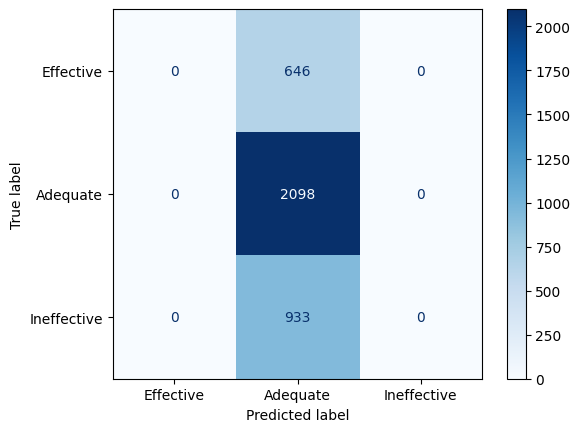

In [43]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predicted.argmax(axis =1), display_labels=labels, cmap=plt.cm.Blues)

In [44]:
print(classification_report(output_df['true_label'], output_df['predicted_label'], target_names = labels))

              precision    recall  f1-score   support

   Effective       0.00      0.00      0.00       646
    Adequate       0.57      1.00      0.73      2098
 Ineffective       0.00      0.00      0.00       933

    accuracy                           0.57      3677
   macro avg       0.19      0.33      0.24      3677
weighted avg       0.33      0.57      0.41      3677



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
